In [54]:
import numpy as np
import scipy as sp
import os
import glob
import matplotlib.pyplot as plt
import imageio

from sklearn import manifold
from sklearn import decomposition

# The Minimal model

The results from a run with the following settings.

- 1 culture
- 4 agents
- 2 nearest neighbours for interactions
- 10 artefacts selected for each epoch


In [93]:
data_path = "../data/output/output_2020-06-21T11-19-23.npy"

x = np.load(data_path, allow_pickle=True)

artefacts = np.array([a[5] for a in x])
agent_ids = np.array([a[1] for a in x])

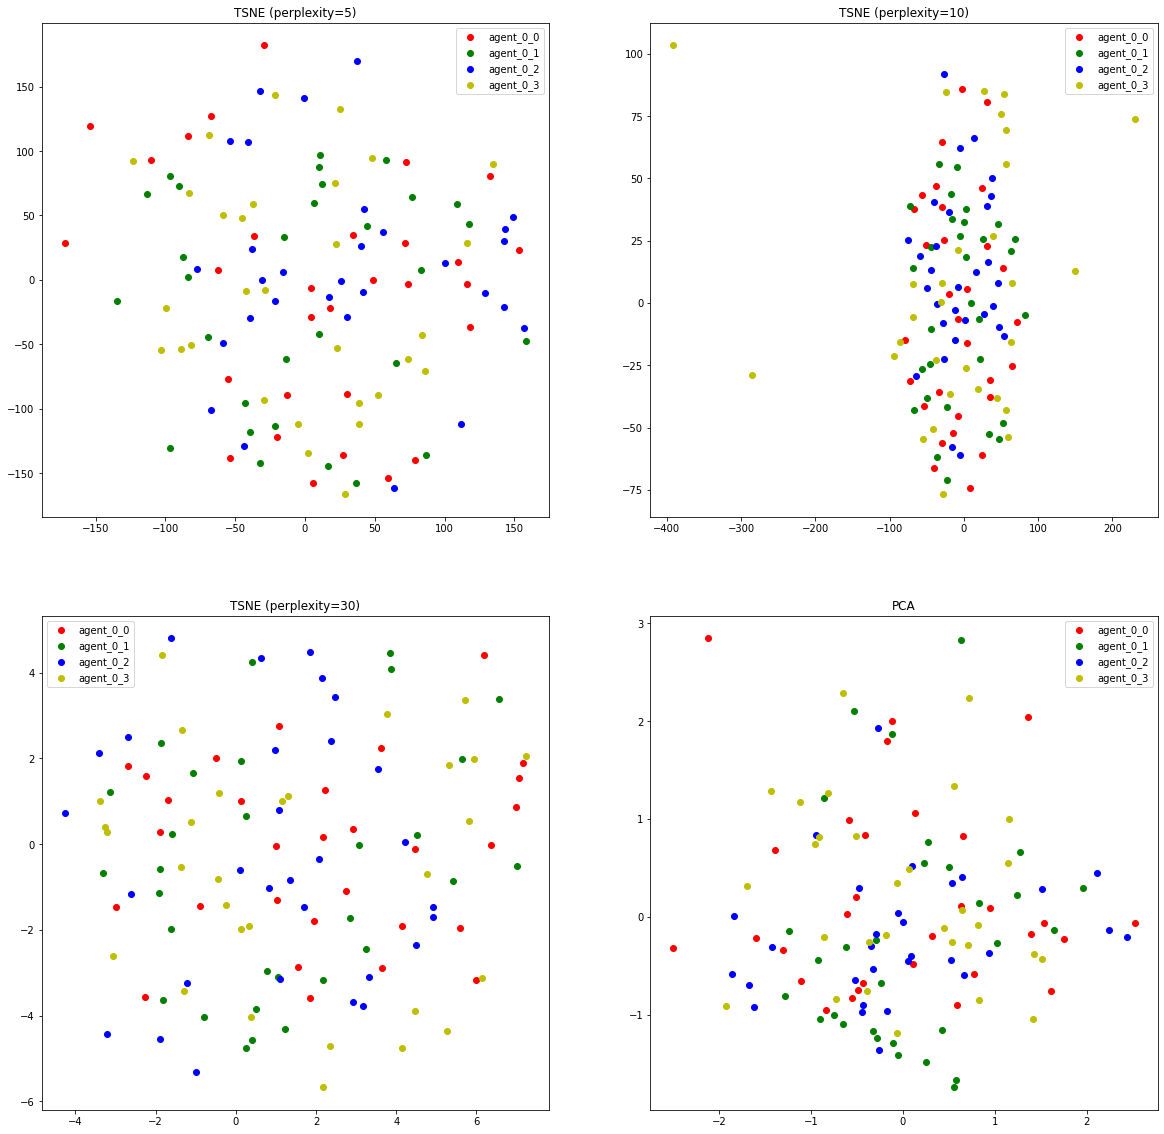

Number of artefacts: 120


In [106]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

labels = ["agent_0_0", "agent_0_1", "agent_0_2", "agent_0_3"]
colors = ["r", "g", "b", "y"]

perplexities = [5, 10, 30]

for i, ax in enumerate(axs.flatten()):
    if i < 3:
        tsne = manifold.TSNE(n_components=2, random_state=1, perplexity=perplexities[i])
        embedded = tsne.fit_transform(artefacts)
        ax.set_title(f"TSNE (perplexity={perplexities[i]})")
    else:
        pca = decomposition.PCA(n_components=2)
        embedded = pca.fit_transform(artefacts)
        ax.set_title("PCA")

    for i, label in enumerate(labels):
        x, y = embedded[i::4, 0], embedded[i::4, 1]
        ax.scatter(x, y, c=colors[i % 4], label=label)
    
    ax.legend()

plt.show()
print(f"Number of artefacts: {len(artefacts)}")

No clusters are forming. Which is not strange at all, since all these agents belong to the same culture. Under the current circumstances, a minimal model, with randomly selecting artefacts, no cliques are formed.

I tried various perplexities, and finally PCA for compariso but I'm not sure what else to do with this.

In [61]:
tsne = manifold.TSNE(n_components=2, perplexity=5, random_state=1)
embedded = tsne.fit_transform(artefacts)

frames = [embedded[:i] for i in range(1, len(embedded) + 2)]
fcolors = [colors[:i] for i in range(1, len(colors) + 2)]

for i, frame in enumerate(frames):
    plt.scatter(frame[:,0], frame[:,1], c=fcolors[i])
    plt.gca().set_ylim(-200, 200)
    plt.gca().set_xlim(-200, 200)
    plt.savefig(f"animations/frame_{i:04d}.png")
    plt.close()

anim_file = 'tsne.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('animations/frame_*.png')
    filenames = sorted(filenames)
    last = -1
    
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 4)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        
        image = imageio.imread(filename)
        writer.append_data(image)

    image = imageio.imread(filename)
    writer.append_data(image)

print('Gif Generated!')

Gif Generated!


### TSNE - Animting artefact in chronological order. Per epoch per agent.
<img src="tsne_200.gif" />

In [115]:
volumes = []

pca = decomposition.PCA(n_components=3)
pca_embedded = pca.fit_transform(artefacts)

hull = sp.spatial.ConvexHull(pca_embedded[:4], incremental=True)
volumes.append(hull.volume)

for i in range(4, len(artefacts)):
    hull.add_points([pca_embedded[i]])
    volumes.append(hull.volume)

hull.close()

Ideally, I want to calculate the volume of the points in 32d-space. But unfortunately, this can't be done for the larger datasets. I used PCA because of its speed and when using TSNE the distance between the points means nothing.

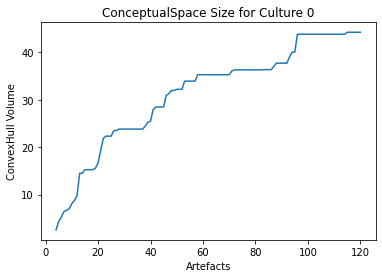

In [116]:
plt.plot(range(4, len(volumes) + 4), volumes)
plt.gca().set_title("Conceptual Space size for Culture 0")
plt.gca().set_ylabel('ConvexHull Volume')
plt.gca().set_xlabel('Artefacts')
plt.show()

The graph below is to check if the model deteriorates after training on a few samples every epoch.

It shows the losses on the seed, after every 10th epoch (to reduce the computational cost). Strangely, the loss still increase even though it just trains on a few new samples. You would expect the model to overfit on those samples.

Now the validation is the same as the seed. In the future, I should generate a validation seed, and then generate baselines when seeding the initial models.

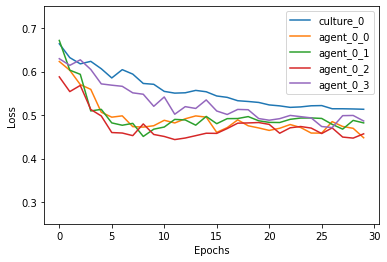

In [84]:
data_eval_path = "../data/output/output_2020-06-21T11-19-23_validation.npy"
evaluations = np.load(data_eval_path, allow_pickle=True)

labels = ["culture_0", "agent_0_0", "agent_0_1", "agent_0_2","agent_0_3"]

fig, ax = plt.subplots(1, 1)
for i, evaluation in enumerate(evaluations):
    ax.plot(range(len(evaluation)), evaluation, label=labels[i])

ax.set_ylabel('Loss')
ax.set_xlabel('Epochs')
ax.set_ylim(.25, .75)
plt.legend()
plt.show()